<a href="https://colab.research.google.com/github/mpfoster/Biochem6765/blob/master/Intro_fitting_python_6765_sp21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to data fitting in Python for Biochem 6765 - SP21; Foster
This notebook is intended to serve as a tutorial guide for introducing students to data fitting in Python. It is by no means a complete description of capabilities or possibilities for data analysis in Python, but hopefully provides some useful guides and examples. 

Have fun! 2021-01-06 MPF

## Data fitting with Python, using Matplotlib and Pandas
We will start with a cooperative isotherm of oxygen binding to hemoglobin. The data can be loaded from a file, or entered as lists of $x$ and $y$ values. We will read the values from a _.csv_ (comma separated values) file.

In [ ]:
# import matplotlib library for MATLAB-like plotting
import matplotlib.pyplot as plt  # this library has the plotting tools
%matplotlib inline 
plt.style.use('ggplot') # one of many available plot styles

We will read in the data using the `pandas` package, https://pandas.pydata.org/. Pandas simplifies loading tabular data into a "data frame"; basically a table with rows and columns. For this example, we will load a `.csv` (comma-separated-values) file that looks like this:
```
pO2,Y
0.499,0.000
1.341,0.015
2.106,0.030
5.345,0.146
7.934,0.316
11.132,0.505
14.761,0.644
18.499,0.760
25.233,0.919
64.028,0.995
```
The first row has column labels; the rest are data. We can either drag/drop the file into the Jupter window with our Jupter script, or specify the path to the file. Now, we tell Pandas to load the data in the file into a data frame. [(See Pandas docs.)](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_table.html)

In [ ]:
# use pandas to load the data from a url
import pandas as pd
df = pd.read_csv("hb+o2.csv")
df  # print out the data frame

,pO2,Y
0,0.499,0.000
1,1.341,0.015
2,2.106,0.030
3,5.345,0.146
4,7.934,0.316
5,11.132,0.505
6,14.761,0.644
7,18.499,0.760
8,25.233,0.919
9,64.028,0.995


and... easily plot the data using funtions associated with a pandas data frame:

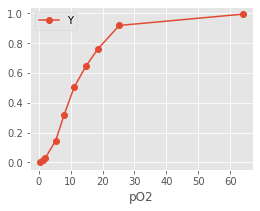

In [ ]:
df.plot('pO2', 'Y', style='o-', figsize=(4,3)) # plot the data using a scatter plot

NB: we can convert a column in a data frame to a list:

In [ ]:
df['Ys'].tolist() # print a column as a list

[0.0, 0.015, 0.03, 0.146, 0.316, 0.505, 0.644, 0.76, 0.919, 0.995]

We can also perform standard statistical analysis using built-in Pandas functions:

In [ ]:
df.describe()

,pO2,Y
count,10.000000,10.000000
mean,15.087800,0.433000
std,18.979209,0.384325
min,0.499000,0.000000
25%,2.915750,0.059000
50%,9.533000,0.410500
75%,17.564500,0.731000
max,64.028000,0.995000


## Fitting to a model
OK, we have loaded and plotted the binding data. It's common in Biochemistry to model cooperative binding of multiple ligands to a macromolecule using the Hill equation: 

$$Y=\frac{[L]^n}{[L]^n+K_D^n}$$

where _n_ is the Hill coefficient, $K_D$ is the equilibrium dissociation constant and $[L]$ the free ligand concentration. We'll have more to say later about the Hill equation, but for now we'll just say that it's commonly used and can generate curves that fit cooperative binding data.


Next, we need to write out the Hill equation in a form that Python will understand. We will do this in the form of a _function_, so we can call and re-use the function by name; e.g., the square root function `sqrt()`.

In [ ]:
# When you call the Hill function, you want it to return Y as determined by
#  the other supplied parameters:
def Hill(x, n, Kd): # the Hill equation
    return x**n/(x**n + Kd**n) 

Having defined a function, it can be useful to guess some paramaters for the model and plot the model along with the data.

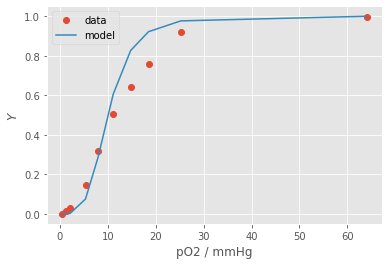

In [54]:
calc_Y = Hill(df.pO2, 4,10) 
# we chose n = 4 here since there are 4 binding sites; and Kd =10 since 
# Y ~ 0.5 at pO2 ~10
# now plot the Y and calc_Y against the same x values:
plt.plot(df.pO2, df.Y,'o', label='data')
plt.plot(df.pO2, calc_Y, label='model')
plt.xlabel('pO2 / mmHg'); plt.ylabel('$Y$')
plt.legend(); plt.show()

We evaluate the goodness of fit by computing a chi-square ($\chi^2$), the squared sum of the residual differences between the data and the model evaluated at each $x$ value:
$$\chi^2 =  \sum_i\left(obs(x)-calc(x)\right)^2 = \sum_i (residuals)^2$$


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


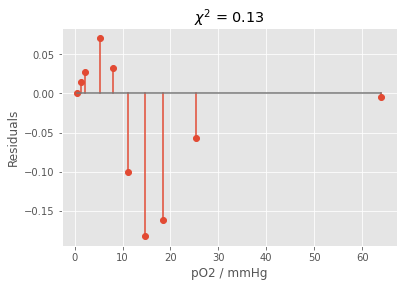

In [59]:
residuals = data - calc_Y
plt.stem(df.pO2,residuals)
plt.xlabel('pO2 / mmHg'); plt.ylabel('Residuals')
plt.title('$\chi^2$ = %.2f' % (sum(residuals))**2 )
plt.show()

Fitting involves finding parameters that generate a **best fit** between the _data_ and the _model_. Because the Hill equation model is not a straight line, we call this _non-linear curve fitting_. (The mathematics for linear regression is much more straightforward.)

There's more than one way to perform nonlinear fitting in python, and we will use the `lmfit` package https://lmfit.github.io/lmfit-py/ to generate the model and perfom fitting. `lmfit` has some nice features but is not a standard package in most python installations (it is built on other standard packages, especially `numpy` and `scipy`), and therefore needs to be installed (esp. for use in Colab). From a Jupyter Notebook, packaged installation can often be accomplished using [`pip`, the package installer for Python](https://pypi.org/project/pip/), which will search online databases for named packages, and install them if possible:
```
!pip install lmfit
```


In [ ]:
# install lmfit
!pip install lmfit

To fit the data with the model, we have to define a _fitting object_ that knows what is the mathematical model (here, the Hill equation), and which parameters are independent (not to be optimized).

In [61]:
from lmfit import Model #, Parameter, report_fit  # import the desired components
# simplest usage:
x = df.pO2; data = df.Y
hmodel = Model(Hill, independent_vars=['x'])
result = hmodel.fit(data, x=x, n=4, Kd=10) # guess some starting values and store them
# ... in a Python oject, here called 'result'
result # echo the contents of the result object

Next, we plot the data, along with the best-fit model, and the residuals; ALWAYS visually inspect the data, fit and residuals before interpreting parameters.

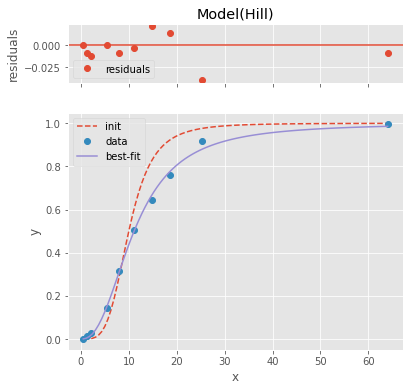

In [63]:
result.plot(numpoints=100, show_init=True) # numpoints for the best fit curve 
plt.show()

The best-fit parameters and other statistics are printed above, and can be individually accessed by name:

In [ ]:
print('Best-fit n: {:.1f}; Kd: {:.1f}'.format(
    result.params['n'].value, result.params['Kd'].value))

Best-fit n: 2.4; Kd: 11.1


If desired, we can append to the dataframe the initial values, best-fit, and residuals of the fit:

In [66]:
df['init'] = result.init_fit
df['best'] = result.best_fit
df['residuals'] = result.residual
df.head()

,pO2,Y,init,best,residuals
0,0.499,0.000,0.000006,0.000556,0.000556
1,1.341,0.015,0.000323,0.006021,-0.008979
2,2.106,0.030,0.001963,0.017705,-0.012295
3,5.345,0.146,0.075460,0.146035,0.000035
4,7.934,0.316,0.283796,0.307506,-0.008494


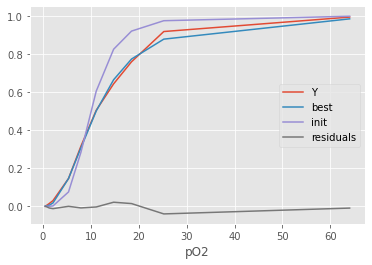

In [70]:
df.plot(x='pO2', y=['Y','best','init','residuals'])